<a href="https://colab.research.google.com/github/hayleypc/HawaiiClimate/blob/main/gen_soil_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from shapely.geometry import Point
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score

In [222]:
def preprocess_data(matched_data):
    # Initial preprocessing
    matched_data['distance'] = 0
    matched_data = matched_data[matched_data["depth_adj_bottom"] == '20']
    matched_data['imp_c_float'] = [float(datum) for datum in matched_data['imp_c']]

    # Select ID fields that are non-numeric since can't run minmax scalar over non numeric
    id_fields = matched_data[['source_dataset', 'island','dist_id', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude']]

    # Select numeric columns and preprocess
    keep_cols = ['water', 'trees','grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub', 'built',
                 'bare', 'snow_and_ice', 'max', 'elevation', 'landform', 'SRTM_mTPI','aet', 'def',
                 'pdsi', 'pet', 'pr', 'ro', 'soil', 'srad', 'swe', 'tmmn','tmmx', 'vap', 'vpd', 'vs',
                 'agbd_m', 'agbd_sd', 'agbd_n']
    numeric_cols = matched_data[keep_cols]
    numeric_cols.replace('', np.nan, inplace=True)
    numeric_cols = numeric_cols.astype(float)
    numeric_cols.fillna(0, inplace=True)

    # Scale numeric columns
    scaler = MinMaxScaler()
    scaler.fit(numeric_cols)
    scaled_numeric_cols = scaler.transform(numeric_cols)
    scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)

    #min max scale imp_c, keep scalers
    min_c = np.min(matched_data['imp_c_float'])
    max_c = np.max(matched_data['imp_c_float'])
    scaled_imp_c = (matched_data['imp_c_float'] - min_c) / (max_c - min_c)

    # Combine ID fields with scaled numeric data
    numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)

    numeric_df['imp_c_scaled'] = scaled_imp_c

    return numeric_df, scaler, min_c, max_c

In [ ]:
def train_model_a(preprocess_data):

    keep_cols = ['water', 'trees','grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub', 'built',
                'bare', 'snow_and_ice', 'max', 'elevation', 'landform', 'SRTM_mTPI','aet', 'def',
                'pdsi', 'pet', 'pr', 'ro', 'soil', 'srad', 'swe', 'tmmn','tmmx', 'vap', 'vpd', 'vs',
                'agbd_m', 'agbd_sd', 'agbd_n']

    X = preprocess_data[keep_cols]

    y = preprocess_data['imp_c_scaled']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define model
    def build_model(input_shape):
        model = Sequential([
            Dense(256, activation='relu', input_dim=input_shape),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(512, activation='relu'),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(1024, activation='relu'),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(1, activation='linear')
        ])
        return model

    model = build_model(X_train.shape[1])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=128, verbose=1)

    test_loss = model.evaluate(X_test, y_test)
    predictions = model.predict(X_test).flatten()
    r_squared = r2_score(y_test, predictions)

    return model, test_loss, r_squared, predictions, y_test

In [4]:
# imputed SOC dostributions
file_path = '/content/drive/MyDrive/hawaii_soils/HI soils data/annotated_combo_imputed_SOC.gpkg'

gdf = gpd.read_file(file_path)

In [310]:
def predict_on_reserve(preprocess_data, model, min_c, max_c):

    df_out = preprocess_data.copy()
    keep_cols = ['water', 'trees','grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub', 'built',
                'bare', 'snow_and_ice', 'max', 'elevation', 'landform', 'SRTM_mTPI','aet', 'def',
                'pdsi', 'pet', 'pr', 'ro', 'soil', 'srad', 'swe', 'tmmn','tmmx', 'vap', 'vpd', 'vs',
                'agbd_m', 'agbd_sd', 'agbd_n']

    X = preprocess_data[keep_cols]
    y = preprocess_data['imp_c_scaled']

    # Predictions and Evaluation
    predictions = model.predict(X)

    inversed_predictions =  predictions*max_c+min_c

    inversed_truth =  y*max_c+min_c

    df_out['predictions'] = predictions
    df_out['inversed_predictions'] = inversed_predictions
    df_out['inversed_imp_c'] = inversed_truth

    return df_out

In [7]:
def evaluate_model(model, X_test, y_test, scaler, inversed_predictions, inversed_truth):
    test_loss = model.evaluate(X_test, y_test)
    r_squared = r2_score(inversed_truth, inversed_predictions)

    print("Test Loss:", test_loss)
    print("R-Squared Score:", r_squared)

    mae = mean_absolute_error(inversed_truth, inversed_predictions)
    rmse = mean_squared_error(inversed_truth, inversed_predictions, squared=False)

    print("Mean Absolute Error (MAE):", mae)
    print("Root Mean Squared Error (RMSE):", rmse)

    # Scatter plot of true vs predicted values
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=inversed_truth, y=inversed_predictions)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title("True vs Predicted Values")
    plt.plot([min(inversed_truth), max(inversed_truth)], [min(inversed_truth), max(inversed_truth)], 'r')  # Diagonal line
    plt.show()

    # Residual plot
    residuals = inversed_truth - inversed_predictions
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.xlabel("Residuals")
    plt.title("Distribution of Residuals")
    plt.show()

# Assuming model, test_loss, r_squared, inversed_predictions, inversed_truth, X_test, and y_test are already computed
# model, test_loss, r_squared, inversed_predictions, inversed_truth, scaler, X_test, y_test = preprocess_and_train_model(matched_data)
# evaluate_model(model, X_test, y_test, scaler, inversed_predictions, inversed_truth)




In [9]:
file_path = '/content/drive/My Drive/sequence_data.csv'

In [10]:
drivers_gpd = gpd.read_file('/content/drive/MyDrive/hawaii_soils/Analysis Data/250_summary_grid_dt.gpkg')

In [11]:
soils_csv = gpd.read_file('/content/drive/MyDrive/hawaii_soils/HI soils data/combined_soc_2024_04_05.csv')

In [279]:
# Filter the DataFrame using .loc
soils_csv = soils_csv.loc[(soils_csv['latitude'] != '') & (soils_csv['longitude'] != '')]

# Create geometry column
soils_csv['geometry'] = soils_csv.apply(lambda row: Point(float(row['longitude']), float(row['latitude'])), axis=1)

# Convert to GeoDataFrame
soils_gpd = gpd.GeoDataFrame(soils_csv, geometry='geometry', crs="EPSG:4326")


In [280]:
soils_gpd = pd.merge(soils_gpd, gdf.loc[:,['dist_id','unique_id']], on='unique_id', how='inner')

In [281]:
# Ensure both GeoDataFrames have the same CRS
soils_gpd = soils_gpd.to_crs(drivers_gpd.crs)

# Perform spatial join
matched_data = gpd.sjoin_nearest(soils_gpd, drivers_gpd, how='left', distance_col='distance')

In [282]:
# Apply a buffer to each geometry in one of the GeoDataFrames (e.g., soils_gpd)
soils_buffered = soils_gpd.copy()

soils_buffered.geometry = soils_buffered.to_crs(epsg=32604).geometry.buffer(1000).to_crs('ESRI:102261')

# soils_gpd = soils_gpd
# Step 2: Spatial Join
# Perform a spatial join with the buffered GeoDataFrame
# This finds all drivers_gpd points that fall within the 10,000-meter buffer of any point in soils_gpd
matches_within_distance = gpd.sjoin(soils_buffered, drivers_gpd, how='left', predicate='intersects')


In [283]:
numeric_df, scaler, min_c, max_c = preprocess_data(matches_within_distance)

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<ipython-input-222-48d85629ab51>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


array(['20'], dtype=object)

In [288]:
frequency_table = numeric_df['unique_id'].value_counts().reset_index()
frequency_table.columns = ['unique_id', 'count']
frequency_table['count'].unique()

array([52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 38, 37, 36, 35,
       34, 33, 32, 31, 30, 29, 28, 27, 26, 22,  3,  1])

In [225]:
# selecting one random distribution id to leave out for cross validation
xval_id = np.random.choice(numeric_df['dist_id'].unique())

In [228]:
# reserve_data = numeric_df[numeric_df['dist_id']!=xval_id].groupby('unique_id').sample(n=1)
# reserve_data

In [290]:
reserve_data = numeric_df[numeric_df['dist_id']!=xval_id].groupby('unique_id').sample(n=1)
reserve_data

,source_dataset,island,dist_id,soil_column_id,unique_id,depth_top,depth_bottom,depth_adj_bottom,latitude,longitude,...,swe,tmmn,tmmx,vap,vpd,vs,agbd_m,agbd_sd,agbd_n,imp_c_scaled
0,FIA,Kauai,NaN,FIA_1060,FIA1,0,20,20,22.185643,-159.350787,...,0.0,0.919650,0.946761,0.947442,0.833200,0.510523,0.016828,0.030577,0.137931,0.064231
100,FIA,Oahu,NaN,FIA_1433,FIA101,0,20,20,21.475448,-157.984458,...,0.0,0.900208,0.934330,0.924736,0.816007,0.514500,0.094650,0.164560,0.551724,0.064954
105,FIA,Oahu,NaN,FIA_1454,FIA106,0,20,20,21.419936,-157.906723,...,0.0,0.871936,0.909543,0.898124,0.762932,0.542160,0.044217,0.070038,0.465517,0.143556
10,FIA,Kauai,NaN,FIA_1077,FIA11,0,20,20,22.152306,-159.380618,...,0.0,0.818287,0.885699,0.885619,0.657210,0.487529,0.205160,0.517108,0.086207,0.099888
110,FIA,Oahu,NaN,FIA_1457,FIA111,0,20,20,21.404189,-157.854121,...,0.0,0.876864,0.910243,0.898774,0.769978,0.544770,0.000000,0.000000,0.000000,0.039570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5997,SH,Kauai,NaN,SH94-01,SH95,0,15,20,21.967096,-159.692819,...,0.0,0.902048,0.954855,0.950564,0.826877,0.519562,0.004020,0.007715,0.086207,0.113633
5998,SH,Kauai,NaN,SH94-01,SH96,0,15,20,21.967096,-159.692819,...,0.0,0.902048,0.954855,0.950564,0.826877,0.519562,0.002663,0.008040,0.103448,0.076609
5999,SH,Kauai,NaN,SH97-01,SH97,0,15,20,21.9670959,-159.692819,...,0.0,0.902048,0.954855,0.950564,0.826877,0.519562,0.006749,0.009302,0.137931,0.107264
6000,SH,Kauai,NaN,SH97-01,SH98,0,15,20,21.9670959,-159.692819,...,0.0,0.902048,0.954855,0.950564,0.826877,0.519562,0.000306,0.000000,0.017241,0.025221


In [291]:
reserve_data = numeric_df[numeric_df['dist_id']!=xval_id].groupby('unique_id').sample(n=1)
reserve_data

,source_dataset,island,dist_id,soil_column_id,unique_id,depth_top,depth_bottom,depth_adj_bottom,latitude,longitude,...,swe,tmmn,tmmx,vap,vpd,vs,agbd_m,agbd_sd,agbd_n,imp_c_scaled
0,FIA,Kauai,NaN,FIA_1060,FIA1,0,20,20,22.185643,-159.350787,...,0.0,0.919650,0.946761,0.947442,0.833200,0.510523,0.049059,0.124622,0.068966,0.064231
100,FIA,Oahu,NaN,FIA_1433,FIA101,0,20,20,21.475448,-157.984458,...,0.0,0.900208,0.934330,0.924736,0.816007,0.514500,0.078824,0.148215,0.241379,0.064954
105,FIA,Oahu,NaN,FIA_1454,FIA106,0,20,20,21.419936,-157.906723,...,0.0,0.887293,0.920565,0.910170,0.790353,0.539879,0.039453,0.044276,0.379310,0.143556
10,FIA,Kauai,NaN,FIA_1077,FIA11,0,20,20,22.152306,-159.380618,...,0.0,0.849930,0.904856,0.904350,0.711917,0.491875,0.126932,0.231857,0.051724,0.099888
110,FIA,Oahu,NaN,FIA_1457,FIA111,0,20,20,21.404189,-157.854121,...,0.0,0.876864,0.910243,0.898774,0.769978,0.544770,0.030351,0.065481,0.137931,0.039570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5997,SH,Kauai,NaN,SH94-01,SH95,0,15,20,21.967096,-159.692819,...,0.0,0.902048,0.954855,0.950564,0.826877,0.519562,0.002138,0.002781,0.068966,0.113633
5998,SH,Kauai,NaN,SH94-01,SH96,0,15,20,21.967096,-159.692819,...,0.0,0.902048,0.954855,0.950564,0.826877,0.519562,0.000651,0.002159,0.137931,0.076609
5999,SH,Kauai,NaN,SH97-01,SH97,0,15,20,21.9670959,-159.692819,...,0.0,0.902048,0.954855,0.950564,0.826877,0.519562,0.003482,0.014753,0.172414,0.107264
6000,SH,Kauai,NaN,SH97-01,SH98,0,15,20,21.9670959,-159.692819,...,0.0,0.902048,0.954855,0.950564,0.826877,0.519562,0.000000,0.000000,0.000000,0.025221


In [292]:
# numeric_df[numeric_df['unique_id'] == 'FIA1']

In [311]:
# Use the function with your DataFrame
reserve_data = numeric_df[numeric_df['dist_id']!=xval_id].groupby('unique_id').sample(n=1)
r2_list = []
loss_list = []
prediction_list = []
matched_data_list = []
model_list = []
for i in range(10):
  matched_data = numeric_df[numeric_df['dist_id']!=xval_id].groupby('unique_id').sample(n=1)
  matched_data = matched_data.reset_index(drop=True)
  model, test_loss, r_squared, predictions, y_test = train_model_a(matched_data)
  predictions = predict_on_reserve(reserve_data, model, min_c, max_c)
  matched_data_list.append(matched_data)
  prediction_list.append(predictions)
  model_list.append(model)

Epoch 1/100
14/14 [==============================] - 2s 19ms/step - loss: 2.1307 - val_loss: 0.0307
Epoch 2/100
14/14 [==============================] - 0s 7ms/step - loss: 1.6448 - val_loss: 0.0204
Epoch 3/100
14/14 [==============================] - 0s 7ms/step - loss: 1.1009 - val_loss: 0.0207
Epoch 4/100
14/14 [==============================] - 0s 7ms/step - loss: 0.9411 - val_loss: 0.0217
Epoch 5/100
14/14 [==============================] - 0s 7ms/step - loss: 0.7457 - val_loss: 0.0182
Epoch 6/100
14/14 [==============================] - 0s 6ms/step - loss: 0.6461 - val_loss: 0.0187
Epoch 7/100
14/14 [==============================] - 0s 7ms/step - loss: 0.5693 - val_loss: 0.0214
Epoch 8/100
14/14 [==============================] - 0s 7ms/step - loss: 0.4610 - val_loss: 0.0196
Epoch 9/100
14/14 [==============================] - 0s 7ms/step - loss: 0.4031 - val_loss: 0.0213
Epoch 10/100
14/14 [==============================] - 0s 7ms/step - loss: 0.3374 - val_loss: 0.0178
Epoch 11

In [312]:
keep_cols = ['water', 'trees','grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub', 'built',
            'bare', 'snow_and_ice', 'max', 'elevation', 'landform', 'SRTM_mTPI','aet', 'def',
            'pdsi', 'pet', 'pr', 'ro', 'soil', 'srad', 'swe', 'tmmn','tmmx', 'vap', 'vpd', 'vs',
            'agbd_m', 'agbd_sd', 'agbd_n']

# X = preprocess_data[keep_cols]

# [model.predict(reserve_data[keep_cols]) for model in model_list]

In [313]:
[np.all(prediction['predictions'] ==prediction_list[0]['predictions']) for prediction in prediction_list]

[True, False, False, False, False, False, False, False, False, False]

In [314]:
# prediction_list[0]

In [315]:
combined_array = np.array([predictions['predictions'].values for predictions in prediction_list])

In [316]:
combined_array[combined_array < 0 ] = 0

In [198]:
# combined_array[0]

In [317]:
arr_min = np.min(combined_array.flatten())
arr_max = np.max(combined_array.flatten())

In [318]:
arr_max

0.4143471

In [319]:
dist_array = [np.sort(np.array([i[j] for  i in combined_array])) for j in range(combined_array.shape[1])]
norm_dist_array =  [np.sort((np.array([i[j] for  i in combined_array]) - arr_min) / (arr_max-arr_min)) for j in range(combined_array.shape[1])]

In [320]:
norm_dist_array

[array([0.15070552, 0.16126002, 0.16477309, 0.1723021 , 0.18046306,
        0.19868198, 0.2045922 , 0.20518483, 0.20821075, 0.24726897],
       dtype=float32),
 array([0.01398647, 0.05992526, 0.09265756, 0.10223117, 0.10429706,
        0.11649988, 0.12070768, 0.1271945 , 0.1568653 , 0.17923605],
       dtype=float32),
 array([0.1505433 , 0.15699747, 0.17459525, 0.18883468, 0.20210585,
        0.22589785, 0.24036191, 0.2916991 , 0.32737744, 0.36591774],
       dtype=float32),
 array([0.17300975, 0.17649162, 0.1974824 , 0.23049429, 0.23481312,
        0.25913474, 0.262052  , 0.29644412, 0.37688234, 0.38538116],
       dtype=float32),
 array([0.14428955, 0.21177003, 0.22880228, 0.24262021, 0.32928166,
        0.33472556, 0.3524563 , 0.39456907, 0.4205497 , 0.4413554 ],
       dtype=float32),
 array([0.15590909, 0.18209638, 0.1881512 , 0.19573505, 0.19947293,
        0.20556863, 0.23144361, 0.23421714, 0.25827828, 0.2946519 ],
       dtype=float32),
 array([0.18622254, 0.18719082, 0.203461

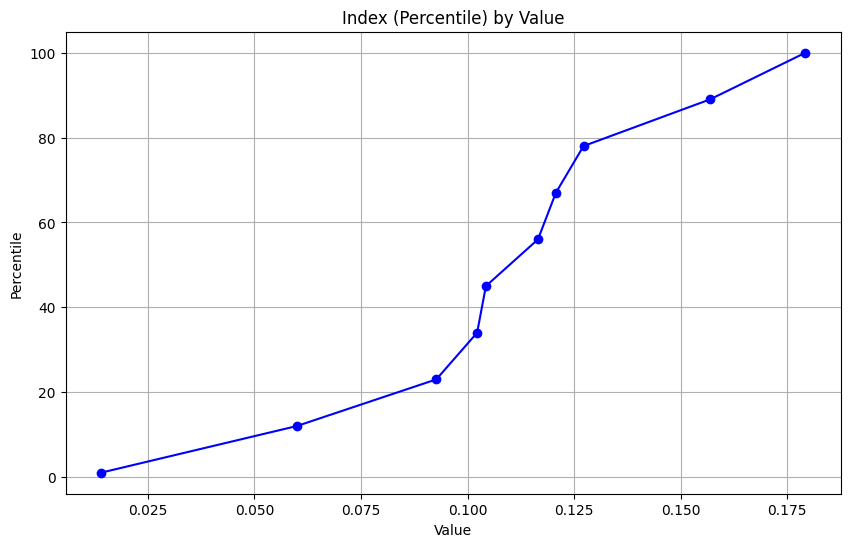

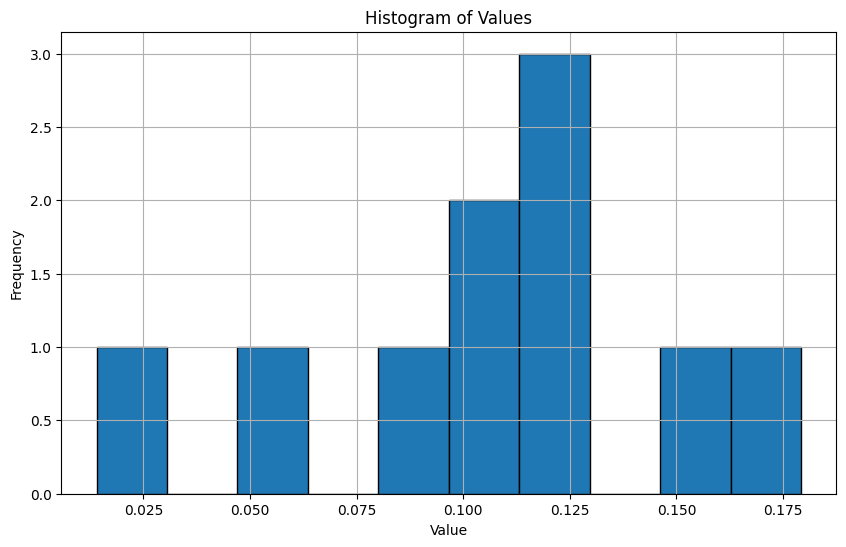

In [321]:
array = norm_dist_array[1]
# Generating y values as indices (percentiles in this context)
y_values = np.linspace(1, 100, len(array))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(array, y_values, marker='o', linestyle='-', color='b')
plt.title('Index (Percentile) by Value')
plt.xlabel('Value')
plt.ylabel('Percentile')
plt.grid(True)
plt.show()

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(array, bins=len(array), edgecolor='black')
plt.title('Histogram of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



need to check the below code block to see if "predictions" is the right data to reference (was previously coded as pred_values)

In [128]:
# scaled_numeric_df

In [105]:
keep_cols = [21,22,23,24,25,26,27,28, 29, 31,32, 33,34,36,36,37,38,39,40,41,42,43,44,45,46,47, 48]

numeric_cols = predictions.iloc[:,keep_cols]

scaler = MinMaxScaler()

scaler.fit(numeric_cols)

scaled_numeric_cols = scaler.transform(numeric_cols)

scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)

scaled_numeric_df['norm_dist_array'] = norm_dist_array

id_fields = predictions[['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude']]

numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)


In [106]:
numeric_df.columns

Index(['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top',
       'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude', 'bottom',
       'water', 'trees', 'grass', 'flooded_vegetation', 'crops',
       'shrub_and_scrub', 'built', 'bare', 'max', 'elevation', 'landform',
       'SRTM_mTPI', 'def', 'def', 'pdsi', 'pet', 'pr', 'ro', 'soil', 'srad',
       'swe', 'tmmn', 'tmmx', 'vap', 'vpd', 'vs', 'norm_dist_array'],
      dtype='object')

In [107]:
# Model Definition
def build_model(input_shape,output_shape):
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_shape),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(512, activation='relu'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(output_shape, activation='linear')  # Adjust output layer according to your needs
    ])
    return model


In [108]:
scaled_numeric_df['norm_dist_array'] = scaled_numeric_df['norm_dist_array'].to_list()

In [109]:
scaled_numeric_df.dropna(inplace=True)

In [110]:
norm_dist_array = np.array([i for i in scaled_numeric_df['norm_dist_array']])

In [111]:

X = scaled_numeric_df.iloc[:, :-1]
y = scaled_numeric_df.iloc[:, -1]

x = np.array(X)
y = np.array(norm_dist_array)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [112]:
# print(X_train.shape[1])
model = build_model(X_train.shape[1],output_shape=10)

In [113]:
y_train.shape

(654, 10)

In [37]:
# X_test

In [120]:
# model = build_model((X_train.shape[1]))
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error',metrics = ['mae'])
# model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=128, verbose=1)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error',metrics = ['mae'])
model.fit(X_train, y_train, validation_split=0.2, epochs=600, batch_size=128, verbose=1)
model.compile(optimizer=Adam(learning_rate=0.00001), loss='mean_squared_error',metrics = ['mae'])
model.fit(X_train, y_train, validation_split=0.2, epochs=600, batch_size=128, verbose=1)

test_loss = model.evaluate(X_test, y_test)

# Predictions and Evaluation
predictions = model.predict(X_test)
# dummy_array = np.full((len(predictions), 28), fill_value=0.5)  # Example for reverse scaling
# dummy_array[:, -1] = predictions
# inversed_predictions = scaler.inverse_transform(dummy_array)[:, -1]
# dummy_array[:, -1] = y_test
# inversed_truth = scaler.inverse_transform(dummy_array)[:, -1]
# r_squared = r2_score(inversed_truth, inversed_predictions)

# return model, test_loss, r_squared, inversed_predictions, scaler

Epoch 1/600
5/5 [==============================] - 2s 56ms/step - loss: 0.0829 - mae: 0.2025 - val_loss: 0.0035 - val_mae: 0.0436
Epoch 2/600
5/5 [==============================] - 0s 11ms/step - loss: 0.0799 - mae: 0.2000 - val_loss: 0.0042 - val_mae: 0.0470
Epoch 3/600
5/5 [==============================] - 0s 11ms/step - loss: 0.0805 - mae: 0.2003 - val_loss: 0.0032 - val_mae: 0.0416
Epoch 4/600
5/5 [==============================] - 0s 11ms/step - loss: 0.0763 - mae: 0.1960 - val_loss: 0.0029 - val_mae: 0.0406
Epoch 5/600
5/5 [==============================] - 0s 11ms/step - loss: 0.0797 - mae: 0.1977 - val_loss: 0.0037 - val_mae: 0.0450
Epoch 6/600
5/5 [==============================] - 0s 11ms/step - loss: 0.0765 - mae: 0.1959 - val_loss: 0.0039 - val_mae: 0.0460
Epoch 7/600
5/5 [==============================] - 0s 11ms/step - loss: 0.0759 - mae: 0.1947 - val_loss: 0.0034 - val_mae: 0.0423
Epoch 8/600
5/5 [==============================] - 0s 12ms/step - loss: 0.0776 - mae: 0.19

ValueError: could not broadcast input array from shape (164,10) into shape (164,)

In [115]:
i = 4
for i in range(5):
  print(predictions[i])
  print(y_test[i])

[-0.08728562 -0.02262482  0.04886379  0.04230111  0.05161922 -0.02828378
  0.02481262  0.02928938 -0.01451084  0.00634712]
[0.         0.         0.         0.         0.         0.00715506
 0.0083793  0.01195068 0.01203473 0.06865263]
[-0.01075757 -0.00711581  0.05101072 -0.03718046  0.05138702  0.08439279
  0.05311972 -0.0431038   0.0177401   0.01308526]
[0.         0.         0.         0.00106089 0.0020298  0.00421593
 0.00686135 0.02270967 0.02752369 0.04851331]
[ 0.03084274 -0.02121975 -0.00609579  0.00016216  0.05879643  0.07299323
 -0.06277316 -0.01912572 -0.0214395   0.05094098]
[0.         0.         0.         0.         0.         0.00079865
 0.01650316 0.01929236 0.03898318 0.03960084]
[ 0.04048278  0.01639463 -0.02265374 -0.00063488  0.00591874  0.02202143
 -0.02057799 -0.00880143  0.06101143  0.01280263]
[0.         0.         0.         0.00019293 0.00338235 0.0098387
 0.00986396 0.01292481 0.02008005 0.04841391]
[ 0.05105521 -0.05236462 -0.03955832  0.02874222 -0.05425

In [40]:
def normal_generator(n, mean, sd, mean_variation, sd_variation):
    variable_mean = mean + np.random.normal(0, mean_variation * 2)
    variable_sd = sd + abs(np.random.normal(0, sd_variation * 2))
    return np.random.normal(variable_mean, variable_sd, n)

def uniform_generator(n, min_val, max_val, min_variation, max_variation):
    variable_min = min_val + np.random.uniform(-min_variation * 2, min_variation * 2)
    variable_max = max_val + np.random.uniform(-max_variation * 2, max_variation * 2)
    return np.random.uniform(variable_min, variable_max, n)

def right_tailed_generator(n, mean, sd, mean_variation, sd_variation):
    variable_mean = mean + np.random.normal(0, mean_variation * 2)
    variable_sd = sd + abs(np.random.normal(0, sd_variation * 2))
    return np.random.lognormal(variable_mean, variable_sd, n)

def left_tailed_generator(n, mean, sd, mean_variation, sd_variation):
    variable_mean = mean + np.random.normal(0, mean_variation * 2)
    variable_sd = sd + abs(np.random.normal(0, sd_variation * 2))
    return -np.random.lognormal(variable_mean, variable_sd, n)

def multimodal_generator(ns, means, sds, mean_variation, sd_variation):
    samples_list = []
    for i in range(len(means)):
        variable_mean = means[i] + np.random.normal(0, mean_variation * 2)
        variable_sd = sds[i] + abs(np.random.normal(0, sd_variation * 2))
        samples_list.append(np.random.normal(variable_mean, variable_sd, ns[i]))
    return np.concatenate(samples_list)

In [41]:
def rescale_to_minus_one_one(values):
    min_value = np.min(values)
    max_value = np.max(values)
    scaled_values = 2 * ((values - min_value) / (max_value - min_value)) - 1
    return scaled_values

In [42]:
def generate_samples(n, q, generator_func, *args):
    samples = generator_func(n, *args)
    samples_q = np.quantile(samples, np.linspace(0, 1, q))
    return rescale_to_minus_one_one(samples_q)

def generate_normal_samples(n=10000, q=10, mean_value=0, sd_value=1, mean_variation=0.5, sd_variation=0.5):
    return generate_samples(n, q, normal_generator, mean_value, sd_value, mean_variation, sd_variation)

def generate_uniform_samples(n=10000, q=10, min_value=-1, max_value=1, min_variation=0.5, max_variation=0.5):
    return generate_samples(n, q, uniform_generator, min_value, max_value, min_variation, max_variation)

def generate_right_tailed_samples(n=10000, q=10, mean=0, sd=1, mean_variation=0.5, sd_variation=0.5):
    return generate_samples(n, q, right_tailed_generator, mean, sd, mean_variation, sd_variation)

def generate_left_tailed_samples(n=10000, q=10, mean=0, sd=1, mean_variation=0.5, sd_variation=0.5):
    return generate_samples(n, q, left_tailed_generator, mean, sd, mean_variation, sd_variation)

def generate_multimodal_samples(ns=[1000, 50], q=10, means=[1, -1], sds=[1, 0.5], mean_variation=0.5, sd_variation=0.5):
    samples = multimodal_generator(ns, means, sds, mean_variation, sd_variation)
    samples_q = np.quantile(samples, np.linspace(0, 1, q))
    return rescale_to_minus_one_one(samples_q)


In [43]:
def generate_training_data(n_samples=10000):
    data_list = {}

    # Generate samples for each distribution type
    data_list['normal'] = [generate_normal_samples() for _ in range(n_samples)]
    data_list['bimodal'] = [generate_multimodal_samples() for _ in range(n_samples)]
    data_list['uniform'] = [generate_uniform_samples() for _ in range(n_samples)]
    data_list['right_tailed'] = [generate_right_tailed_samples() for _ in range(n_samples)]
    data_list['left_tailed'] = [generate_left_tailed_samples() for _ in range(n_samples)]

    # Combine all data into a single DataFrame
    combined_data = pd.DataFrame()
    for name, samples_list in data_list.items():
        df = pd.DataFrame(samples_list)
        df['label'] = name
        combined_data = pd.concat([combined_data, df], ignore_index=True)

    # Assign column names
    combined_data.columns = [f'V{i+1}' for i in range(combined_data.shape[1] - 1)] + ['label']

    return combined_data

In [44]:
training_data = generate_training_data()

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [46]:
# Separate features and labels
X = training_data.drop(columns=['label'])
y = training_data['label']

# Encode labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=500, max_leaf_nodes=50, min_samples_leaf=2, random_state=123)

# Train the model
rf_model.fit(X, y_encoded)

# Print the trained model
print(rf_model)

RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500,
                       random_state=123)


In [47]:
reference_rf_ready_predictions = [rescale_to_minus_one_one(sorted(prediction)) for prediction in  y_test]

In [48]:
# reference_rf_ready_predictions

In [49]:
some_new_data = training_data = generate_training_data()

In [50]:
# predictions

In [51]:
prediction_rf_ready_predictions = [rescale_to_minus_one_one(sorted(prediction)) for prediction in  predictions]

In [52]:
real_quantiles.columns = [f'V{i+1}' for i in range(real_quantiles.shape[1])]

NameError: name 'real_quantiles' is not defined

In [ ]:
real_data_rf_ready_predictions = [rescale_to_minus_one_one(sorted(prediction)) for prediction in  np.array(real_quantiles) ]

In [ ]:
# Assuming real_data_rf_ready_predictions is your list of predictions
real_data_rf_ready_predictions = [prediction for prediction in real_data_rf_ready_predictions if not np.any(np.isnan(prediction))]


In [ ]:
real_data_rf_ready_predictions

In [ ]:
real_quantiles = quantiles.unstack().reset_index().iloc[:,1:]

In [ ]:
real_data_rf_ready_predictions

In [ ]:
# Assuming `new_data` is your new dataset without the 'label' column

# Use the trained model to make predictions
predicted_labels_encoded = rf_model.predict(real_data_rf_ready_predictions)

# Decode the encoded labels back to original labels
predicted_predicted_labels = label_encoder.inverse_transform(predicted_labels_encoded)

# Output the predictions
print(predicted_predicted_labels)


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(predicted_predicted_labels, reference_predicted_labels)


In [ ]:
cm

In [ ]:
import numpy as np
import pandas as pd

# Assuming 'my_array' is your numpy array
unique_values, counts = np.unique(predicted_predicted_labels, return_counts=True)

# Create a DataFrame to display the counts in a table format
counts_table = pd.DataFrame({
    'Unique Value': unique_values,
    'Count': counts
})

# Display the table
print(counts_table)


In [ ]:
import numpy as np
import pandas as pd

# Assuming 'my_array' is your numpy array
unique_values, counts = np.unique(predicted_labels, return_counts=True)

# Create a DataFrame to display the counts in a table format
counts_table = pd.DataFrame({
    'Unique Value': unique_values,
    'Count': counts
})

# Display the table
print(counts_table)


In [ ]:
# matches_within_distance[matches_within_distance['dist_id']!=xval_id].groupby('unique_id').sample(n=1)

In [66]:
xval_data = matches_within_distance[matches_within_distance['dist_id']==xval_id]

0.000000    0.735027
0.111111    0.935904
0.222222    0.994083
0.333333    1.051334
0.444444    1.076923
0.555556    1.106132
0.666667    1.559841
0.777778    1.822485
0.888889    1.883787
1.000000    1.973491
Name: imp_c, dtype: float64

In [76]:
quantiles = xval_data[xval_data['depth_adj_bottom'] =="20" ].groupby('unique_id').sample(n=1)['imp_c'].astype(float).quantile(np.linspace(0, 1,10))

In [116]:
keep_cols = [21,22,23,24,25,26,27,28, 29, 31,32, 33,34,36,36,37,38,39,40,41,42,43,44,45,46,47, 48]

numeric_cols = xval_data.iloc[:,keep_cols]

# scaler = MinMaxScaler()

scaler.fit(numeric_cols)

scaled_numeric_cols = scaler.transform(numeric_cols)

scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)

# scaled_numeric_df['norm_dist_array'] = norm_dist_array

id_fields = xval_data[['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude']]

numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)

In [ ]:
X = scaled_numeric_df.iloc[:, :-1]


In [117]:
predictions = model.predict(scaled_numeric_df)

18/18 [==============================] - 0s 1ms/step


In [119]:
predictions

array([[-0.12247125,  0.03118328,  0.0495691 , ..., -0.19799103,
        -0.28046292,  0.2542506 ],
       [-0.18755071, -0.14517893,  0.05063031, ...,  0.46126023,
         0.10858239, -0.06460682],
       [ 0.19001669, -0.05443947, -0.24050142, ...,  0.2977469 ,
        -0.01477434, -0.05928018],
       ...,
       [ 0.82937247,  0.16018318, -0.10060246, ...,  0.3745603 ,
        -0.26639497,  0.7190533 ],
       [ 0.49430498,  0.14218841, -0.18336594, ...,  0.1484254 ,
        -0.10297315,  0.4973034 ],
       [ 0.38399374,  0.15162261, -0.1568389 , ...,  0.23105922,
        -0.19483854,  0.54415834]], dtype=float32)

In [122]:
dummy_array = np.full((len(predictions), 28), fill_value=0.5)  # Example for reverse scaling
dummy_array[:, -1] = predictions
inversed_predictions = scaler.inverse_transform(dummy_array)[:, -1]
dummy_array[:, -1] = y_test
inversed_truth = scaler.inverse_transform(dummy_array)[:, -1]

ValueError: could not broadcast input array from shape (164,10) into shape (164,)